In [ ]:
import polars as pl
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import gc

# 讀取 parquet
train_filled = pl.read_parquet("data/train_filled_v1_with_all.parquet")
test_filled = pl.read_parquet("data/test_filled_v1_with_all.parquet")

# 讀取 top features
df = pd.read_csv("model_output/all_features_xgb/v1_add_company_ID/v1_model/model_importance/common_features_with_ranks.csv")
filtered_features = df[df["min_rank_overall"] != 9999]["feature"].tolist()

cols_to_keep = filtered_features + ["ranker_id", "companyID"]

# 篩選
train_filled = train_filled.select(cols_to_keep)
test_filled = test_filled.select([c for c in cols_to_keep if c in test_filled.columns])

print(f"✅ Train欄位數: {len(train_filled.columns)}")
print(f"✅ Test欄位數: {len(test_filled.columns)}")

# 隨機抽樣
train_sample = train_filled.sample(n=250000, seed=42)
del train_filled
gc.collect()

test_sample = test_filled.sample(n=250000, seed=42)
del test_filled
gc.collect()

# 加來源標籤
train_sample = train_sample.with_columns(pl.lit(0).alias("target"))  # train = 0
test_sample = test_sample.with_columns(pl.lit(1).alias("target"))   # test = 1

# 確認共同欄位
common_cols = [c for c in train_sample.columns if c in test_sample.columns]
print(f"✅ 共有欄位: {common_cols}")

# 統一型別
def unify_dtypes(df):
    return df.with_columns([
        (
            pl.col(c).cast(pl.Float32)
            if df.schema[c] in pl.NUMERIC_DTYPES
            else pl.col(c).cast(pl.Utf8)
        )
        for c in df.columns
    ])

train_sample = unify_dtypes(train_sample)
test_sample = unify_dtypes(test_sample)


# 合併
# 合併
sample_all = pl.concat([train_sample, test_sample]).sample(fraction=1.0, seed=42) # shuffle全部

print(f"✅ 合併後 shape: {sample_all.shape}")


✅ Train欄位數: 201
✅ Test欄位數: 201
✅ 共有欄位: ['total_num_transfers_rank', 'legs0_segments0_flightNumber', 'price_per_duration_rank', 'price_percentile', 'price_from_median_zscore', 'price_per_duration', 'legs0_segments0_baggageAllowance_quantity', 'price_minus_fee_rank', 'legs0_arrivalAt_hour', 'pricingInfo_isAccessTP', 'legs0_departureAt_hour', 'both_legs_carrier_all_same', 'total_weighted_mean_cabin', 'price_per_fee_rank', 'totalPrice_rank', 'days_before_departure', 'legs0_segments0_seatsAvailable', 'price_per_fee', 'price_per_tax', 'legs1_main_carrier', 'isVip', 'leg0_view_diff_mean', 'legs1_departureAt_hour', 'baggage_total', 'duration_ratio', 'total_fees', 'all_view_diff_mean', 'legs1_arrivalAt_hour', 'log_price', 'legs1_segments0_flightNumber', 'legs1_weighted_mean_cabin', 'companyID_loo_mean_legs0_departureAt_hour', 'legs0_segments0_cabinClass', 'price_minus_fee', 'legs0_main_carrier', 'companyID_loo_mean_legs0_arrivalAt_hour', 'baggage_total_rank', 'legs0_max_duration_cabin', 'legs0_

/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_32060/717746128.py:48: DeprecationWarning: `NUMERIC_DTYPES` was deprecated in version 1.0.0. Define your own data type groups or use the `polars.selectors` module for selecting columns of a certain data type.
  if df.schema[c] in pl.NUMERIC_DTYPES


✅ 合併後 shape: (500000, 202)


In [33]:
import polars as pl
import pandas as pd

# 先 concat
sample_all = pl.concat([train_sample, test_sample])

# 轉 Pandas
df_pd = sample_all.to_pandas()

# Pandas shuffle
df_pd = df_pd.sample(frac=1.0, random_state=42).reset_index(drop=True)

# 再轉回 Polars
sample_all = pl.from_pandas(df_pd)



In [59]:
import polars as pl
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

# ✅ 假設你的 sample_all 已經準備好
print(f"✅ 合併後 shape: {sample_all.shape}")

# 把 Utf8 欄視為 categorical
categorical_cols = [c for c, dtype in sample_all.schema.items() if dtype == pl.Utf8]
print(f"✅ Categorical columns: {categorical_cols}")

# ✅ 直接轉成 pandas
df_pd = sample_all.to_pandas()

# ✅ 明確把categorical欄轉 pandas category dtype
for c in categorical_cols:
    df_pd[c] = df_pd[c].astype("category")

# 分離 X / y
X = df_pd.drop(columns=["target", "ranker_id", "companyID","leg0_view_diff_mean", 'companyID_loo_mean_legs0_departureAt_hour', "companyID_loo_mean_legs0_arrivalAt_hour", "companyID_loo_mean_taxes"])
y = df_pd["target"].values

# ✅ train/val split
X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# ✅ DMatrix 支援 category columns
dtrain = xgb.DMatrix(X_train, label=y_train,  enable_categorical=True)
dval = xgb.DMatrix(X_val, label=y_val, enable_categorical=True)

# ✅ XGBoost 訓練
params = {
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "max_depth": 6,
    "learning_rate": 0.1,
    "n_jobs": -1,
    "seed": 42,
}
bst = xgb.train(
    params,
    dtrain,
    num_boost_round=200,
    evals=[(dval, "validation")],
    early_stopping_rounds=20,
    verbose_eval=10
)

# 預測 AUC
y_pred = bst.predict(dval)
auc = roc_auc_score(y_val, y_pred)
print(f"\n🎯 Domain shift AUC = {auc:.4f}")

if auc < 0.6:
    print("✅ 幾乎沒有 domain shift")
elif auc < 0.75:
    print("⚠️ 中等 domain shift")
else:
    print("🚨 嚴重 domain shift")


✅ 合併後 shape: (500000, 202)
✅ Categorical columns: ['ranker_id']
[0]	validation-auc:0.91458
[10]	validation-auc:0.94078
[20]	validation-auc:0.95039
[30]	validation-auc:0.95946
[40]	validation-auc:0.96675
[50]	validation-auc:0.97168
[60]	validation-auc:0.97487
[70]	validation-auc:0.97793
[80]	validation-auc:0.97987
[90]	validation-auc:0.98181
[100]	validation-auc:0.98320
[110]	validation-auc:0.98450
[120]	validation-auc:0.98552
[130]	validation-auc:0.98655
[140]	validation-auc:0.98739
[150]	validation-auc:0.98802
[160]	validation-auc:0.98859
[170]	validation-auc:0.98903
[180]	validation-auc:0.98948
[190]	validation-auc:0.99003
[199]	validation-auc:0.99039

🎯 Domain shift AUC = 0.9904
🚨 嚴重 domain shift


/opt/anaconda3/envs/FlightRank/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/FlightRank/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24067 (\N{CJK UNIFIED IDEOGRAPH-5E03}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


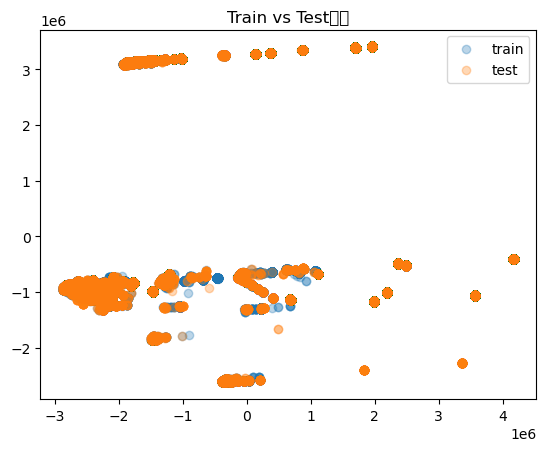

In [66]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.fillna(0))

plt.scatter(X_pca[y==0,0], X_pca[y==0,1], alpha=0.3, label="train")
plt.scatter(X_pca[y==1,0], X_pca[y==1,1], alpha=0.3, label="test")
plt.legend()
plt.title("Train vs Test分布")
plt.show()


In [65]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# 分離 X / y
X = df_pd.drop(columns=["target", "ranker_id", "companyID","leg0_view_diff_mean","leg1_view_diff_mean","all_view_diff_mean"])
y = df_pd["target"].values

# ✅ train/val split
X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

lr = LogisticRegression(max_iter=100)
lr.fit(X_train.fillna(0), y_train)
y_pred_lr = lr.predict_proba(X_val.fillna(0))[:,1]
auc_lr = roc_auc_score(y_val, y_pred_lr)
print(f"LogisticRegression AUC: {auc_lr:.4f}")


LogisticRegression AUC: 0.6437


/opt/anaconda3/envs/FlightRank/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
# 取得 importance dict
importance = bst.get_score(importance_type="weight")  # 可選 'weight', 'gain', 'cover'

# 轉成 DataFrame 方便看
importance_df = (
    pd.DataFrame(
        importance.items(),
        columns=["feature", "importance"]
    )
    .sort_values("importance", ascending=False)
)

print("\n🎯 Top 20 重要特徵：")
print(importance_df.head(20))





🎯 Top 20 重要特徵：
                                       feature  importance
94                    legs0_segments0_duration       385.0
75                  all_flight_view_count_rank       323.0
19                         leg0_view_diff_mean       302.0
1                 legs0_segments0_flightNumber       272.0
36              legs0_segments0_key_view_count       248.0
37                              total_duration       239.0
58                         leg1_view_diff_mean       213.0
47               legs0_segments0_aircraft_code       196.0
65                              legs0_duration       191.0
52                       all_flight_view_count       166.0
67                                 searchRoute       164.0
24                          all_view_diff_mean       164.0
29   companyID_loo_mean_legs0_departureAt_hour       164.0
62                         corporateTariffCode       159.0
100                   legs1_segments0_duration       150.0
42                    companyID_loo_mean

In [53]:
for col in X.columns:
    if pd.api.types.is_numeric_dtype(X[col]):
        print(f"{col}: train_mean={X_train[col].mean():.4f}, test_mean={X_val[col].mean():.4f}")
    else:
        print(f"{col}: train uniques={X_train[col].nunique()}, test uniques={X_val[col].nunique()}")


total_num_transfers_rank: train_mean=1.2762, test_mean=1.2744
legs0_segments0_flightNumber: train_mean=3591.6479, test_mean=3592.6084
price_per_duration_rank: train_mean=110.6323, test_mean=111.0009
price_percentile: train_mean=0.5036, test_mean=0.5033
price_from_median_zscore: train_mean=0.3329, test_mean=0.3304
price_per_duration: train_mean=102.1374, test_mean=102.4841
legs0_segments0_baggageAllowance_quantity: train_mean=2.4961, test_mean=2.4237
price_minus_fee_rank: train_mean=60.8797, test_mean=61.0251
legs0_arrivalAt_hour: train_mean=13.4496, test_mean=13.4431
pricingInfo_isAccessTP: train_mean=0.5356, test_mean=0.5368
legs0_departureAt_hour: train_mean=13.5000, test_mean=13.4922
both_legs_carrier_all_same: train_mean=0.6035, test_mean=0.6069
total_weighted_mean_cabin: train_mean=1.1263, test_mean=1.1255
price_per_fee_rank: train_mean=61.4055, test_mean=61.4878
totalPrice_rank: train_mean=56.0838, test_mean=56.2267
days_before_departure: train_mean=14.2555, test_mean=14.1988
leg

In [50]:
# 取前20個特徵
top20_features = importance_df.head(164)["feature"].tolist()

# 移除Top 20特徵
X_reduced = X.drop(columns=top20_features)

# 再次切分
X_train2, X_val2, y_train2, y_val2 = train_test_split(
    X_reduced,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# 再次訓練
dtrain2 = xgb.DMatrix(X_train2, label=y_train2, enable_categorical=True)
dval2 = xgb.DMatrix(X_val2, label=y_val2, enable_categorical=True)

bst2 = xgb.train(
    params,
    dtrain2,
    num_boost_round=200,
    evals=[(dval2, "validation")],
    early_stopping_rounds=20,
    verbose_eval=10
)

# 預測新AUC
y_pred2 = bst2.predict(dval2)
auc2 = roc_auc_score(y_val2, y_pred2)
print(f"\n🎯 第二次 (去掉Top 20特徵) Domain shift AUC = {auc2:.4f}")

if auc2 < 0.6:
    print("✅ 幾乎沒有 domain shift")
elif auc2 < 0.75:
    print("⚠️ 中等 domain shift")
else:
    print("🚨 嚴重 domain shift")

[0]	validation-auc:0.57662
[10]	validation-auc:0.57847
[20]	validation-auc:0.58052
[30]	validation-auc:0.58169
[40]	validation-auc:0.58249
[50]	validation-auc:0.58409
[60]	validation-auc:0.58469
[70]	validation-auc:0.58497
[80]	validation-auc:0.58543
[90]	validation-auc:0.58560
[100]	validation-auc:0.58564
[110]	validation-auc:0.58600
[120]	validation-auc:0.58607
[130]	validation-auc:0.58621
[140]	validation-auc:0.58633
[150]	validation-auc:0.58650
[160]	validation-auc:0.58659
[170]	validation-auc:0.58666
[180]	validation-auc:0.58679
[190]	validation-auc:0.58689
[199]	validation-auc:0.58695

🎯 第二次 (去掉Top 20特徵) Domain shift AUC = 0.5870
✅ 幾乎沒有 domain shift


In [ ]:
import polars as pl

# 假設 train_filled 已經存在
df = (
    train_filled
    .sort(["ranker_id"])  # 確保排序穩定
    .with_row_count("global_index")
    .with_columns(
        (pl.col("global_index") - pl.col("global_index").min().over("ranker_id")).alias("relative_index")
    )
)

# 看正例的index分布
selected_counts = (
    df.filter(pl.col("selected") == 1)
    .group_by("relative_index")
    .count()
    .sort("relative_index")
)

import matplotlib.pyplot as plt
# 把Polars DataFrame轉Pandas
selected_counts_pd = selected_counts.to_pandas()

# 總正例數
total_selected = selected_counts_pd["count"].sum()

# 加上百分比與累積百分比
selected_counts_pd["percent"] = selected_counts_pd["count"] / total_selected * 100
selected_counts_pd["cumulative_percent"] = selected_counts_pd["percent"].cumsum()

# 顯示
print(selected_counts_pd[])


/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_86720/3956469533.py:7: DeprecationWarning: `DataFrame.with_row_count` is deprecated; use `with_row_index` instead. Note that the default column name has changed from 'row_nr' to 'index'.
  .with_row_count("global_index")


      relative_index  count    percent  cumulative_percent
0                  0  17320  16.410995           16.410995
1                  1  10927  10.353519           26.764514
2                  2   5243   4.967832           31.732345
3                  3   4736   4.487441           36.219786
4                  4   5977   5.663309           41.883095
...              ...    ...        ...                 ...
1713            6144      1   0.000948           99.996210
1714            6385      1   0.000948           99.997157
1715            6945      1   0.000948           99.998105
1716            7015      1   0.000948           99.999052
1717            7281      1   0.000948          100.000000

[1718 rows x 4 columns]


/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_86720/3956469533.py:17: DeprecationWarning: `GroupBy.count` was renamed; use `GroupBy.len` instead
  .count()


In [24]:
# 把Polars轉Pandas
selected_counts_pd = selected_counts.to_pandas()

# 計算總數
total_selected = selected_counts_pd["count"].sum()

# 加百分比和累積百分比
selected_counts_pd["percent"] = selected_counts_pd["count"] / total_selected * 100
selected_counts_pd["cumulative_percent"] = selected_counts_pd["percent"].cumsum()

# 找第一個 >=95% 的relative_index
row_95 = selected_counts_pd[selected_counts_pd["cumulative_percent"] >= 95].iloc[0]

index_95 = row_95["relative_index"]

print(f"✅ 95% 的被選資料都集中在 relative_index <= {int(index_95)}")


✅ 95% 的被選資料都集中在 relative_index <= 292


In [1]:
import polars as pl
import pandas as pd

# 讀取 parquet
train_filled = pl.read_parquet("data/train_filled.parquet")

# 讀取top50 features
n_top = 20
save_dir = "model_output/selected_features_xgb/one_model"
df = pd.read_csv("model_output/all_features_xgb/model_importance/common_features_with_ranks.csv")
top50_features = df["feature"].head(n_top).tolist()

# 你要保留的欄位 (Top50 + target + group id)
cols_to_keep = top50_features + ["selected", "ranker_id"]

# 只保留這些欄位
train_filled = train_filled.select(cols_to_keep)

print(f"✅ DataFrame 現在只有 {len(train_filled.columns)} 欄位: {train_filled.columns}")


✅ DataFrame 現在只有 22 欄位: ['total_num_transfers_rank', 'total_is_min_transfers', 'legs0_num_transfers_rank', 'price_from_median_zscore', 'price_percentile', 'legs0_segments0_flightNumber', 'price_per_duration', 'price_per_duration_rank', 'companyID', 'has_access_tp', 'pricingInfo_isAccessTP', 'days_before_departure', 'legs0_mean_cabin', 'price_minus_fee_rank', 'price_per_fee', 'price_per_fee_rank', 'both_legs_carrier_all_same', 'legs0_arrivalAt_hour', 'legs0_departureAt_hour', 'price_per_tax', 'selected', 'ranker_id']


In [13]:
# 對每個 ranker_id 加上 relative_index
train_filled = (
    train_filled
    .with_row_count("global_index")  # 整體 index
    .with_columns([
        (
            (pl.col("global_index") - pl.col("global_index").min().over("ranker_id"))
            .alias("relative_index")
        )
    ])
    .drop("global_index")
)
train_filled = train_filled.filter(
    pl.col("relative_index") <= 292
)
print("✅ 篩選完畢")


/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_43934/3103210226.py:4: DeprecationWarning: `DataFrame.with_row_count` is deprecated; use `with_row_index` instead. Note that the default column name has changed from 'row_nr' to 'index'.
  .with_row_count("global_index")  # 整體 index


✅ 篩選完畢


In [14]:
train_filled

total_num_transfers_rank,total_is_min_transfers,legs0_num_transfers_rank,price_from_median_zscore,price_percentile,legs0_segments0_flightNumber,price_per_duration,price_per_duration_rank,companyID,has_access_tp,pricingInfo_isAccessTP,days_before_departure,legs0_mean_cabin,price_minus_fee_rank,price_per_fee,price_per_fee_rank,both_legs_carrier_all_same,legs0_arrivalAt_hour,legs0_departureAt_hour,price_per_tax,selected,ranker_id,relative_index
u32,i8,u32,f64,f64,i32,f64,u32,i64,i32,f64,i32,f64,i32,f64,i32,i8,i8,i8,f64,i64,str,u32
1,1,1,-1.947024,0.04,1274,53.43038,9,57323,1,1.0,29,1.0,5,16884.0,3,1,16,15,45.509434,1,"""98ce0dabf6964640b63079fbafd42c…",0
2,0,2,-0.135934,0.18,4360,53.759201,10,57323,1,1.0,29,1.0,4,8.813136,5,0,14,9,22.813476,0,"""98ce0dabf6964640b63079fbafd42c…",1
2,0,2,0.0,0.42,4360,56.461619,11,57323,1,1.0,29,1.0,3,9.256163,4,0,14,9,23.960286,0,"""98ce0dabf6964640b63079fbafd42c…",2
2,0,2,1.490774,0.66,4360,86.098843,20,57323,1,1.0,29,1.0,2,81880.0,2,0,14,9,36.53726,0,"""98ce0dabf6964640b63079fbafd42c…",3
2,0,2,1.712393,0.9,4360,90.504732,21,57323,1,1.0,29,1.0,1,86070.0,1,0,14,9,38.406961,0,"""98ce0dabf6964640b63079fbafd42c…",4
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
1,1,1,0.260413,0.65678,1750,83.734219,177,54154,0,0.0,6,1.0,42,16.791472,62,1,14,10,6.437803,0,"""88f8c53a28bf4f438941fd67338009…",288
1,1,1,0.345135,0.728814,1750,89.049834,190,54154,0,0.0,6,1.0,36,17.857428,57,1,14,10,6.846488,0,"""88f8c53a28bf4f438941fd67338009…",289
1,1,1,2.407844,0.887288,1750,218.468439,223,54154,0,0.0,6,2.0,6,65759.0,6,1,14,10,16.796679,0,"""88f8c53a28bf4f438941fd67338009…",290


In [3]:
import os
import numpy as np
import polars as pl
from lightgbm import Booster

# 參數
model_path = "model_output/selected_features_xgb/one_model/top20/lgb_classifer_model.txt"

# 讀取模型 (用Booster)
booster = Booster(model_file=model_path)

# 確認 feature_names
model_features = booster.feature_name()
if model_features is None:
    raise ValueError("❌ 模型沒有 feature_names，請確認訓練時有指定 feature_names")
print(f"✅ 模型共 {len(model_features)} 個features")


print(f"✅ 讀取 train_filled {train_filled.height} rows")

# 檢查缺失
missing_in_data = [f for f in model_features if f not in train_filled.columns]
if missing_in_data:
    raise ValueError(f"❌ 下列特徵在 test_filled 不存在: {missing_in_data}")

# 篩選
df_for_predict = train_filled.select(model_features)
X_np = df_for_predict.to_numpy()

# 預測 (Booster.predict 直接回傳概率)
preds = booster.predict(X_np)
print(f"✅ 預測完成，共 {len(preds)} 筆")

# 回存結果
train_filled = (
    train_filled
    .with_columns([
        pl.Series("predict_rank_selected", preds)
    ])
)


✅ 模型共 20 個features
✅ 讀取 train_filled 10347221 rows
✅ 預測完成，共 10347221 筆


In [4]:
import os
import polars as pl

def add_predict_rank_feature(
    test_filled_with_preds: pl.DataFrame,
):
    """
    根據 test_filled_with_preds 輸出兩個 parquet:
    1. 原始分數 (selected)
    2. rank 排序 (selected)
    """
    # Rank 排名
    ranked_df = test_filled_with_preds.with_columns(
        pl.col("predict_rank_selected")
          .rank(method="ordinal", descending=True)
          .over("ranker_id")
          .alias("predict_rank_selected")
    )
    return ranked_df
    
train_filled = add_predict_rank_feature(
    test_filled_with_preds=train_filled,   # 你的帶有 selected 分數的 DataFrame
)
train_filled['predict_rank_selected']

predict_rank_selected
u32
1
2
11
14
15
…
588
590
582


In [12]:
mean_rank = (
    train_filled
    .filter(pl.col("selected") == 1)
    ["predict_rank_selected"]
    .mean()
)
print(f"✅ 正例平均排名: {mean_rank:.2f}")


✅ 正例平均排名: 15.46


In [15]:
exclude_cols = [
    'Id', 'ranker_id', 'selected', "relative_index"
]

feature_cols = [col for col in train_filled.columns if col not in exclude_cols]

print(f"Using {len(feature_cols)} features")

X = train_filled.select(feature_cols)
y = train_filled.select('selected')
groups = train_filled.select('ranker_id')

Using 20 features


In [16]:
import numpy as np
import polars as pl

# 先把 ranker_id轉list
unique_rankers = groups.select("ranker_id").unique().to_series().to_list()

# 打亂
np.random.seed(42)
np.random.shuffle(unique_rankers)

# 切8:2
n_train = int(0.8 * len(unique_rankers))
train_rankers = set(unique_rankers[:n_train])
val_rankers = set(unique_rankers[n_train:])

# 用 Polars 過濾 train/val
is_train = groups.select(pl.col("ranker_id").is_in(list(train_rankers)).alias("is_train"))

# 先 concat mask
X_with_mask = X.with_columns(is_train)
y_with_mask = y.with_columns(is_train)
groups_with_mask = groups.with_columns(is_train)

# 分割 DataFrame
X_train_df = X_with_mask.filter(pl.col("is_train"))
X_val_df = X_with_mask.filter(~pl.col("is_train"))
y_train_df = y_with_mask.filter(pl.col("is_train"))
y_val_df = y_with_mask.filter(~pl.col("is_train"))
groups_train_df = groups_with_mask.filter(pl.col("is_train"))
groups_val_df = groups_with_mask.filter(~pl.col("is_train"))

# 再轉 numpy (分批)
X_train_np = X_train_df.drop("is_train").to_numpy()
X_val_np = X_val_df.drop("is_train").to_numpy()
y_train_np = y_train_df.drop("is_train").to_numpy().flatten()
y_val_np = y_val_df.drop("is_train").to_numpy().flatten()
groups_train_np = groups_train_df.drop("is_train").to_numpy().flatten()
groups_val_np = groups_val_df.drop("is_train").to_numpy().flatten()
# 最後計算 group sizes
group_sizes_train = (
    groups_train_df.drop("is_train")
    .group_by("ranker_id", maintain_order=True)
    .agg(pl.len())['len']
    .to_numpy()
)

group_sizes_val = (
    groups_val_df.drop("is_train")
    .group_by("ranker_id", maintain_order=True)
    .agg(pl.len())['len']
    .to_numpy()
)


In [17]:
import xgboost as xgb

# DMatrix 建立 (不再用 X.columns)
dtrain = xgb.DMatrix(
    X_train_np,
    label=y_train_np,
    feature_names = feature_cols,
)
dtrain.set_group(group_sizes_train)

dval = xgb.DMatrix(
    X_val_np,
    label=y_val_np,
    feature_names = feature_cols,

)
dval.set_group(group_sizes_val)


Found the probability is way higher then rank. Also ✅ 95% 的被選資料都集中在 relative_index <= 292

In [19]:

# 參數
xgb_params = {
    'objective': 'rank:pairwise',
    'eval_metric': 'ndcg@3',
    'max_depth': 10,
    'min_child_weight': 10,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'lambda': 10.0,
    'learning_rate': 0.05,
    'seed': 42,
    'n_jobs': -1,
}

# 訓練
xgb_model = xgb.train(
    xgb_params,
    dtrain,
    num_boost_round=500,
    evals=[(dtrain, "train"), (dval, "val")],
    early_stopping_rounds=50,
    verbose_eval=20
)
# 存成二進位模型
import os
model_path = os.path.join(save_dir, f"try{n_top}")
os.makedirs(model_path, exist_ok=True)
model_path = os.path.join(save_dir, f"try{n_top}/xgb_3_292_ranker_model.bin")

xgb_model.save_model(model_path)
print(f"✅ 已儲存模型到 'xgb_ranker_model.bin' in {model_path}")

import polars as pl
from scripts.hitrate import compute_hitrate_at_3
# 預測
val_preds = xgb_model.predict(dval)

# 計算 HitRate
compute_hitrate_at_3(groups_val_np, y_val_np, val_preds)


[0]	train-ndcg@3:0.37106	val-ndcg@3:0.36613
[20]	train-ndcg@3:0.45433	val-ndcg@3:0.42808
[40]	train-ndcg@3:0.47571	val-ndcg@3:0.43935
[60]	train-ndcg@3:0.49156	val-ndcg@3:0.44527
[80]	train-ndcg@3:0.50499	val-ndcg@3:0.45205
[100]	train-ndcg@3:0.51681	val-ndcg@3:0.45780
[120]	train-ndcg@3:0.52747	val-ndcg@3:0.46359
[140]	train-ndcg@3:0.53879	val-ndcg@3:0.46622
[160]	train-ndcg@3:0.55024	val-ndcg@3:0.46958
[180]	train-ndcg@3:0.56002	val-ndcg@3:0.47405
[200]	train-ndcg@3:0.57058	val-ndcg@3:0.47639
[220]	train-ndcg@3:0.58091	val-ndcg@3:0.48135
[240]	train-ndcg@3:0.59218	val-ndcg@3:0.48489
[260]	train-ndcg@3:0.60275	val-ndcg@3:0.48739
[280]	train-ndcg@3:0.61362	val-ndcg@3:0.48982
[300]	train-ndcg@3:0.62298	val-ndcg@3:0.49241
[320]	train-ndcg@3:0.63364	val-ndcg@3:0.49470
[340]	train-ndcg@3:0.64333	val-ndcg@3:0.49723
[360]	train-ndcg@3:0.65198	val-ndcg@3:0.49906
[380]	train-ndcg@3:0.66339	val-ndcg@3:0.50107
[400]	train-ndcg@3:0.67275	val-ndcg@3:0.50311
[420]	train-ndcg@3:0.68141	val-ndcg@3:0.

/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_43934/105249660.py:30: UserWarning: [01:06:12] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1748292887431/work/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  xgb_model.save_model(model_path)


✅ HitRate@3 (groups size in [10, inf]): 0.5188


0.5188431200701139

In [12]:

# 參數
xgb_params = {
    'objective': 'rank:pairwise',
    'eval_metric': 'ndcg@3',
    'max_depth': 10,
    'min_child_weight': 10,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'lambda': 10.0,
    'learning_rate': 0.05,
    'seed': 42,
    'n_jobs': -1,
}

# 訓練
xgb_model = xgb.train(
    xgb_params,
    dtrain,
    num_boost_round=500,
    evals=[(dtrain, "train"), (dval, "val")],
    early_stopping_rounds=50,
    verbose_eval=20
)
# 存成二進位模型
import os
model_path = os.path.join(save_dir, f"try{n_top}")
os.makedirs(model_path, exist_ok=True)
model_path = os.path.join(save_dir, f"try{n_top}/xgb_2_ranker_model.bin")

xgb_model.save_model(model_path)
print(f"✅ 已儲存模型到 'xgb_ranker_model.bin' in {model_path}")

import polars as pl
from scripts.hitrate import compute_hitrate_at_3
# 預測
val_preds = xgb_model.predict(dval)

# 計算 HitRate
compute_hitrate_at_3(groups_val_np, y_val_np, val_preds)


[0]	train-ndcg@3:0.32094	val-ndcg@3:0.31807
[20]	train-ndcg@3:0.40533	val-ndcg@3:0.37640
[40]	train-ndcg@3:0.42648	val-ndcg@3:0.38588
[60]	train-ndcg@3:0.44293	val-ndcg@3:0.39341
[80]	train-ndcg@3:0.45797	val-ndcg@3:0.39966
[100]	train-ndcg@3:0.46916	val-ndcg@3:0.40521
[120]	train-ndcg@3:0.47856	val-ndcg@3:0.40981
[140]	train-ndcg@3:0.48974	val-ndcg@3:0.41291
[160]	train-ndcg@3:0.49998	val-ndcg@3:0.41686
[180]	train-ndcg@3:0.50977	val-ndcg@3:0.42072
[200]	train-ndcg@3:0.51741	val-ndcg@3:0.42181
[220]	train-ndcg@3:0.52606	val-ndcg@3:0.42494
[240]	train-ndcg@3:0.53529	val-ndcg@3:0.42775
[260]	train-ndcg@3:0.54393	val-ndcg@3:0.42862
[280]	train-ndcg@3:0.55448	val-ndcg@3:0.43220
[300]	train-ndcg@3:0.56467	val-ndcg@3:0.43512
[320]	train-ndcg@3:0.57356	val-ndcg@3:0.43648
[340]	train-ndcg@3:0.58157	val-ndcg@3:0.43954
[360]	train-ndcg@3:0.58954	val-ndcg@3:0.44164
[380]	train-ndcg@3:0.59676	val-ndcg@3:0.44300
[400]	train-ndcg@3:0.60517	val-ndcg@3:0.44510
[420]	train-ndcg@3:0.61230	val-ndcg@3:0.

/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_43934/3936586627.py:30: UserWarning: [17:12:47] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1748292887431/work/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  xgb_model.save_model(model_path)


✅ 已儲存模型到 'xgb_ranker_model.bin' in model_output/selected_features_xgb/one_model/try20/xgb_2_ranker_model.bin
✅ HitRate@3 (groups size in [10, inf]): 0.4752


0.47521480502313285

In [8]:

# 參數
xgb_params = {
    'objective': 'rank:pairwise',
    'eval_metric': 'ndcg@3',
    'max_depth': 10,
    'min_child_weight': 10,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'lambda': 10.0,
    'learning_rate': 0.05,
    'seed': 42,
    'n_jobs': -1,
}

# 訓練
xgb_model = xgb.train(
    xgb_params,
    dtrain,
    num_boost_round=500,
    evals=[(dtrain, "train"), (dval, "val")],
    early_stopping_rounds=50,
    verbose_eval=20
)
# 存成二進位模型
import os
model_path = os.path.join(save_dir, f"try{n_top}")
os.makedirs(model_path, exist_ok=True)
model_path = os.path.join(save_dir, f"try{n_top}/xgb_ranker_model.bin")

xgb_model.save_model(model_path)
print(f"✅ 已儲存模型到 'xgb_ranker_model.bin' in {model_path}")

import polars as pl
from scripts.hitrate import compute_hitrate_at_3
# 預測
val_preds = xgb_model.predict(dval)

# 計算 HitRate
compute_hitrate_at_3(groups_val_np, y_val_np, val_preds)


[0]	train-ndcg@3:0.31820	val-ndcg@3:0.31421
[20]	train-ndcg@3:0.38542	val-ndcg@3:0.36276
[40]	train-ndcg@3:0.40461	val-ndcg@3:0.37398
[60]	train-ndcg@3:0.41798	val-ndcg@3:0.38087
[80]	train-ndcg@3:0.43149	val-ndcg@3:0.38657
[100]	train-ndcg@3:0.44052	val-ndcg@3:0.39139
[120]	train-ndcg@3:0.45182	val-ndcg@3:0.39693
[140]	train-ndcg@3:0.46149	val-ndcg@3:0.40106
[160]	train-ndcg@3:0.47078	val-ndcg@3:0.40537
[180]	train-ndcg@3:0.47954	val-ndcg@3:0.40836
[200]	train-ndcg@3:0.49133	val-ndcg@3:0.41162
[220]	train-ndcg@3:0.50353	val-ndcg@3:0.41605
[240]	train-ndcg@3:0.51653	val-ndcg@3:0.41998
[260]	train-ndcg@3:0.52694	val-ndcg@3:0.42363
[280]	train-ndcg@3:0.53622	val-ndcg@3:0.42620
[300]	train-ndcg@3:0.54607	val-ndcg@3:0.43041
[320]	train-ndcg@3:0.55354	val-ndcg@3:0.43199
[340]	train-ndcg@3:0.56059	val-ndcg@3:0.43420
[360]	train-ndcg@3:0.56856	val-ndcg@3:0.43622
[380]	train-ndcg@3:0.57651	val-ndcg@3:0.43757
[400]	train-ndcg@3:0.58364	val-ndcg@3:0.43951
[420]	train-ndcg@3:0.59081	val-ndcg@3:0.

/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_43934/2388038690.py:30: UserWarning: [16:55:56] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1748292887431/work/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  xgb_model.save_model(model_path)


✅ HitRate@3 (groups size in [10, inf]): 0.4677


0.4677044094837137

In [17]:

# 參數
xgb_params = {
    'objective': 'rank:pairwise',
    'eval_metric': 'ndcg@3',
    'max_depth': 10,
    'min_child_weight': 10,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'lambda': 10.0,
    'learning_rate': 0.05,
    'seed': 42,
    'n_jobs': -1,
}

# 訓練
xgb_model = xgb.train(
    xgb_params,
    dtrain,
    num_boost_round=500,
    evals=[(dtrain, "train"), (dval, "val")],
    early_stopping_rounds=50,
    verbose_eval=20
)
# 存成二進位模型
import os
model_path = os.path.join(save_dir, f"try{n_top}")
os.makedirs(model_path, exist_ok=True)
model_path = os.path.join(save_dir, f"try{n_top}/xgb_ranker_model.bin")

xgb_model.save_model(model_path)
print(f"✅ 已儲存模型到 'xgb_ranker_model.bin' in {model_path}")



[0]	train-ndcg@3:0.38453	val-ndcg@3:0.37936
[20]	train-ndcg@3:0.45675	val-ndcg@3:0.42616
[40]	train-ndcg@3:0.47040	val-ndcg@3:0.43193
[60]	train-ndcg@3:0.48145	val-ndcg@3:0.43752
[80]	train-ndcg@3:0.49142	val-ndcg@3:0.44137
[100]	train-ndcg@3:0.49965	val-ndcg@3:0.44483
[120]	train-ndcg@3:0.50610	val-ndcg@3:0.44609
[140]	train-ndcg@3:0.51306	val-ndcg@3:0.44938
[160]	train-ndcg@3:0.51937	val-ndcg@3:0.45088
[180]	train-ndcg@3:0.52682	val-ndcg@3:0.45509
[200]	train-ndcg@3:0.53623	val-ndcg@3:0.45753
[220]	train-ndcg@3:0.54557	val-ndcg@3:0.46015
[240]	train-ndcg@3:0.55233	val-ndcg@3:0.46180
[260]	train-ndcg@3:0.55959	val-ndcg@3:0.46431
[280]	train-ndcg@3:0.56592	val-ndcg@3:0.46582
[300]	train-ndcg@3:0.57175	val-ndcg@3:0.46769
[320]	train-ndcg@3:0.57762	val-ndcg@3:0.46941
[340]	train-ndcg@3:0.58359	val-ndcg@3:0.47080
[360]	train-ndcg@3:0.58897	val-ndcg@3:0.47198
[380]	train-ndcg@3:0.59439	val-ndcg@3:0.47310
[400]	train-ndcg@3:0.59949	val-ndcg@3:0.47496
[420]	train-ndcg@3:0.60353	val-ndcg@3:0.

/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_86720/4213556011.py:30: UserWarning: [05:31:18] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1748292887431/work/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  xgb_model.save_model(model_path)


In [18]:
import polars as pl
from scripts.hitrate import compute_hitrate_at_3
# 預測
val_preds = xgb_model.predict(dval)

# 計算 HitRate
compute_hitrate_at_3(groups_val_np, y_val_np, val_preds)


✅ HitRate@3 (groups size in [10, inf]): 0.5163


0.5163463662469626

In [9]:
import polars as pl
from scripts.hitrate import compute_hitrate_at_3
# 預測
val_preds = xgb_model.predict(dval)

# 計算 HitRate
compute_hitrate_at_3(groups_val_np, y_val_np, val_preds)


✅ HitRate@3 (groups size in [10, inf]): 0.4827


0.4827108500498726

# Prediction

In [24]:
import os
import numpy as np
import polars as pl
import xgboost as xgb

# 參數
model_path = "model_output/selected_features_xgb/one_model/try20/xgb_2_ranker_model.bin"
parquet_path = "data/test_filled.parquet"

# 讀取模型
xgb_model = xgb.Booster(model_file=model_path)

# 確認 feature_names
model_features = xgb_model.feature_names
if model_features is None:
    raise ValueError("❌ 模型沒有 feature_names，請確認訓練時有指定 feature_names")
print(f"✅ 模型共 {len(model_features)} 個features")

# 讀取 test_filled
df = pl.read_parquet(parquet_path)
print(f"✅ 讀取 test_filled，共 {df.height} rows")

# 檢查缺失
missing_in_data = [f for f in model_features if f not in df.columns]
if missing_in_data:
    raise ValueError(f"❌ 下列特徵在 test_filled 不存在: {missing_in_data}")

# 篩選&排序
df_for_predict = df.select(model_features)
X_np = df_for_predict.to_numpy()

# 預測
dtest = xgb.DMatrix(X_np, feature_names=model_features)
preds = xgb_model.predict(dtest)
print(f"✅ 預測完成，共 {len(preds)} 筆")

# 回存結果
df_result = (
    df
    .with_columns([
        pl.Series("selected", preds)
    ])
)

# 查看前幾筆
print(df_result.head())


✅ 模型共 20 個features
✅ 讀取 test_filled，共 6897776 rows
✅ 預測完成，共 6897776 筆
shape: (5, 236)
┌──────────┬────────┬───────────┬────────────┬───┬────────────┬────────────┬───────────┬───────────┐
│ Id       ┆ bySelf ┆ companyID ┆ nationalit ┆ … ┆ legs1_segm ┆ legs1_segm ┆ searchRou ┆ selected  │
│ ---      ┆ ---    ┆ ---       ┆ y          ┆   ┆ ents2_flig ┆ ents3_flig ┆ te        ┆ ---       │
│ i64      ┆ i8     ┆ i64       ┆ ---        ┆   ┆ htNumber   ┆ htNumber   ┆ ---       ┆ f32       │
│          ┆        ┆           ┆ i64        ┆   ┆ ---        ┆ ---        ┆ i32       ┆           │
│          ┆        ┆           ┆            ┆   ┆ i32        ┆ i32        ┆           ┆           │
╞══════════╪════════╪═══════════╪════════════╪═══╪════════════╪════════════╪═══════════╪═══════════╡
│ 18144679 ┆ 1      ┆ 62840     ┆ 36         ┆ … ┆ 8790       ┆ -1         ┆ 3236      ┆ 0.201538  │
│ 18144680 ┆ 1      ┆ 62840     ┆ 36         ┆ … ┆ 8790       ┆ -1         ┆ 3236      ┆ 0.363807  │
│ 181

In [ ]:
import os
import numpy as np
import polars as pl
from lightgbm import Booster

# 參數
model_path = "model_output/selected_features_xgb/one_model/top20/lgb_classifer_model.txt"
parquet_path = "data/test_filled.parquet"

# 讀取模型 (用Booster)
booster = Booster(model_file=model_path)

# 確認 feature_names
model_features = booster.feature_name()
if model_features is None:
    raise ValueError("❌ 模型沒有 feature_names，請確認訓練時有指定 feature_names")
print(f"✅ 模型共 {len(model_features)} 個features")

# 讀取 test_filled
df = pl.read_parquet(parquet_path)
print(f"✅ 讀取 test_filled，共 {df.height} rows")

# 檢查缺失
missing_in_data = [f for f in model_features if f not in df.columns]
if missing_in_data:
    raise ValueError(f"❌ 下列特徵在 test_filled 不存在: {missing_in_data}")

# 篩選
df_for_predict = df.select(model_features)
X_np = df_for_predict.to_numpy()

# 預測 (Booster.predict 直接回傳概率)
preds = booster.predict(X_np)
print(f"✅ 預測完成，共 {len(preds)} 筆")

# 回存結果
df_result = (
    df
    .with_columns([
        pl.Series("predict_rank_selected", preds)
    ])
)


[LightGBM] [Fatal] Unknown model format or submodel type in model file model_output/selected_features_xgb/one_model/try20/xgb_3_292_ranker_model.bin


LightGBMError: Unknown model format or submodel type in model file model_output/selected_features_xgb/one_model/try20/xgb_3_292_ranker_model.bin

In [2]:
# 對每個 ranker_id 加上 relative_index
df_result = (
    df_result
    .with_row_count("global_index")  # 整體 index
    .with_columns([
        (
            (pl.col("global_index") - pl.col("global_index").min().over("ranker_id"))
            .alias("relative_index")
        )
    ])
)
# train_filled = train_filled.filter(
#     pl.col("relative_index") <= 292
# )

/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_41710/1613317357.py:4: DeprecationWarning: `DataFrame.with_row_count` is deprecated; use `with_row_index` instead. Note that the default column name has changed from 'row_nr' to 'index'.
  .with_row_count("global_index")  # 整體 index


In [ ]:
import os
import numpy as np
import polars as pl
from lightgbm import Booster

# 參數
model_path = "model_output/selected_features_xgb/one_model/try20/xgb_ranker_model.bin"
import xgboost as xgb

booster = xgb.Booster()
booster.load_model(model_path)

# 確認 feature_names
importance_dict = booster.get_score(importance_type="weight")
model_features = list(importance_dict.keys())
if model_features is None:
    raise ValueError("❌ 模型沒有 feature_names，請確認訓練時有指定 feature_names")
print(f"✅ 模型共 {len(model_features)} 個features")

# 讀取 test_filled
print(f"✅ 讀取 test_filled，共 {df_result.height} rows")

# 檢查缺失
missing_in_data = [f for f in model_features if f not in df_result.columns]
if missing_in_data:
    raise ValueError(f"❌ 下列特徵在 test_filled 不存在: {missing_in_data}")

# 篩選
df_for_predict_2 = df_result.select(model_features)
X_np = df_for_predict_2.to_numpy()
# 準備 DMatrix
import numpy as np
X_dmatrix = xgb.DMatrix(X_np, feature_names=model_features)

# 預測 (Booster.predict 直接回傳概率)
preds = booster.predict(X_dmatrix)
print(f"✅ 預測完成，共 {len(preds)} 筆")

# 回存結果
df_result = (
    df
    .with_columns([
        pl.Series("selected", preds)
    ])
)


✅ 模型共 23 個features
✅ 讀取 test_filled，共 6897776 rows
✅ 預測完成，共 6897776 筆


In [25]:
import os
import polars as pl

def export_submission_parquets(
    test_filled_with_preds: pl.DataFrame,
    output_dir: str,
    raw_filename: str = "raw_submission.parquet",
    ranked_filename: str = "rank_submission.parquet"
):
    """
    根據 test_filled_with_preds 輸出兩個 parquet:
    1. 原始分數 (selected)
    2. rank 排序 (selected)
    """
    # 檢查目錄
    os.makedirs(output_dir, exist_ok=True)

    # Subset + __index_level_0__
    subset_df = (
        test_filled_with_preds
        .select(["Id", "ranker_id", "selected"])
        .with_columns(
            pl.col("Id").alias("__index_level_0__")
        )
        .with_columns([
            pl.col("Id").cast(pl.Int64),
            pl.col("ranker_id").cast(pl.Utf8),
            pl.col("selected").cast(pl.Float64),
            pl.col("__index_level_0__").cast(pl.Int64)
        ])
    )

    # 儲存原始 parquet
    raw_path = os.path.join(output_dir, raw_filename)
    subset_df.write_parquet(raw_path)
    print(f"✅ 已儲存原始 submission: {raw_path}")
    print(subset_df)

    # Rank 排名
    ranked_df = subset_df.with_columns(
        pl.col("selected")
          .rank(method="ordinal", descending=True)
          .over("ranker_id")
          .alias("selected")
    )

    # 儲存排名 parquet
    ranked_path = os.path.join(output_dir, ranked_filename)
    ranked_df.write_parquet(ranked_path)
    print(f"✅ 已儲存rank submission: {ranked_path}")
    print(ranked_df)
    
n_top = 20
export_submission_parquets(
    test_filled_with_preds=df_result,   # 你的帶有 selected 分數的 DataFrame
    output_dir=f"model_output/selected_features_xgb/one_model/try{n_top}",
    ranked_filename = "lgb_rank_2_submission.parquet",
    raw_filename ="lgb_raw_submission.parquet",
)


✅ 已儲存原始 submission: model_output/selected_features_xgb/one_model/try20/lgb_raw_submission.parquet
shape: (6_897_776, 4)
┌──────────┬─────────────────────────────────┬───────────┬───────────────────┐
│ Id       ┆ ranker_id                       ┆ selected  ┆ __index_level_0__ │
│ ---      ┆ ---                             ┆ ---       ┆ ---               │
│ i64      ┆ str                             ┆ f64       ┆ i64               │
╞══════════╪═════════════════════════════════╪═══════════╪═══════════════════╡
│ 18144679 ┆ c9373e5f772e43d593dd6ad2fa90f6… ┆ 0.201538  ┆ 18144679          │
│ 18144680 ┆ c9373e5f772e43d593dd6ad2fa90f6… ┆ 0.363807  ┆ 18144680          │
│ 18144681 ┆ c9373e5f772e43d593dd6ad2fa90f6… ┆ -0.528247 ┆ 18144681          │
│ 18144682 ┆ c9373e5f772e43d593dd6ad2fa90f6… ┆ 0.203674  ┆ 18144682          │
│ 18144683 ┆ c9373e5f772e43d593dd6ad2fa90f6… ┆ 0.28713   ┆ 18144683          │
│ …        ┆ …                               ┆ …         ┆ …                 │
│ 25043143 

In [ ]:
import os
import polars as pl

def add_predict_rank_feature(
    test_filled_with_preds: pl.DataFrame,
):
    """
    根據 test_filled_with_preds 輸出兩個 parquet:
    1. 原始分數 (selected)
    2. rank 排序 (selected)
    """
    # Rank 排名
    ranked_df = test_filled_with_preds.with_columns(
        pl.col("selected")
          .rank(method="ordinal", descending=True)
          .over("ranker_id")
          .alias("selected")
    )
    return ranked_df
    
ranked_df = add_predict_rank_feature(
    test_filled_with_preds=df_result,   # 你的帶有 selected 分數的 DataFrame
)


✅ 已儲存原始 submission: model_output/selected_features_xgb/one_model/top20/lgb_classifer_raw_submission.parquet
shape: (6_897_776, 4)
┌──────────┬─────────────────────────────────┬──────────┬───────────────────┐
│ Id       ┆ ranker_id                       ┆ selected ┆ __index_level_0__ │
│ ---      ┆ ---                             ┆ ---      ┆ ---               │
│ i64      ┆ str                             ┆ f64      ┆ i64               │
╞══════════╪═════════════════════════════════╪══════════╪═══════════════════╡
│ 18144679 ┆ c9373e5f772e43d593dd6ad2fa90f6… ┆ 0.327041 ┆ 18144679          │
│ 18144680 ┆ c9373e5f772e43d593dd6ad2fa90f6… ┆ 0.664309 ┆ 18144680          │
│ 18144681 ┆ c9373e5f772e43d593dd6ad2fa90f6… ┆ 0.120555 ┆ 18144681          │
│ 18144682 ┆ c9373e5f772e43d593dd6ad2fa90f6… ┆ 0.449987 ┆ 18144682          │
│ 18144683 ┆ c9373e5f772e43d593dd6ad2fa90f6… ┆ 0.309593 ┆ 18144683          │
│ …        ┆ …                               ┆ …        ┆ …                 │
│ 25043143 ┆

In [ ]:
from scripts.result_esemble import compute_ranked_average_selected_from_submissions

submission_paths = [
    "model_output/selected_features_xgb/one_model/top60/raw_submission.parquet",
    "model_output/all_features_xgb/2_raw_submission.parquet",
    "model_output/all_features_xgb/raw_submission.parquet",
    "model_output/selected_features_xgb/one_model/top20/raw_submission.parquet"
]

avg_df = compute_ranked_average_selected_from_submissions(submission_paths)

# 顯示前5筆
print(avg_df.head())

# 如需輸出
avg_df.write_parquet("submission_selected_mean.parquet")
print("✅ 已輸出平均submission")


✅ 讀取: model_output/selected_features_xgb/one_model/top60/raw_submission.parquet
✅ 讀取: model_output/all_features_xgb/2_raw_submission.parquet
✅ 讀取: model_output/all_features_xgb/raw_submission.parquet
✅ 讀取: model_output/selected_features_xgb/one_model/top20/raw_submission.parquet
✅ 完成 6897776 筆平均+排名計算
shape: (5, 4)
┌──────────┬─────────────────────────────────┬──────────┬───────────────────┐
│ Id       ┆ ranker_id                       ┆ selected ┆ __index_level_0__ │
│ ---      ┆ ---                             ┆ ---      ┆ ---               │
│ i64      ┆ str                             ┆ u32      ┆ i64               │
╞══════════╪═════════════════════════════════╪══════════╪═══════════════════╡
│ 18144679 ┆ c9373e5f772e43d593dd6ad2fa90f6… ┆ 98       ┆ 18144679          │
│ 18144680 ┆ c9373e5f772e43d593dd6ad2fa90f6… ┆ 32       ┆ 18144680          │
│ 18144681 ┆ c9373e5f772e43d593dd6ad2fa90f6… ┆ 223      ┆ 18144681          │
│ 18144682 ┆ c9373e5f772e43d593dd6ad2fa90f6… ┆ 122      ┆ 18